In [39]:
## path for mdules

import sys
#sys.path.insert(0,"/home/albert/lib/python")

import numpy as np
import xarray as xr
import glob

from netCDF4 import Dataset

sys.path.insert(0,"/home/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
from mpl_toolkits.axes_grid1 import make_axes_locatable

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date

import seaborn as sns
sns.set(color_codes=True)

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import cos, pi 

%matplotlib inline

In [2]:
## Dataset

dirfilt="/home/henelle/Notebooks/Data/"

In [3]:
## JFM & JAS files

tfileJFM = dirfilt + 'ACO_JFM_filtered.nc'
tfileJAS = dirfilt + 'ACO_JAS_filtered.nc'

In [4]:
params = {'font.weight':    'normal',
          'font.size':       int(14),
          'figure.titlesize': 'large',
          'legend.fontsize': int(12),
          'xtick.labelsize': int(14),
          'ytick.labelsize': int(14),
          'axes.labelsize':  int(14)}
mpl.rcParams.update(params)

In [5]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title):
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((-36, -26, 25, 40))
    land = cfeature.GSHHSFeature(scale='intermediate',levels=[1],facecolor=cfeature.COLORS['land'])
    
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                          alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("bottom", size="5%", pad=0.05)
    
    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1,extend='both')
    plt.title(title,fontsize=18)
    #ax.text(0.57, -0.08, date, transform=ax.transAxes)

    ax.plot([-31, -28], [33, 33],color='black',linewidth=4)
    ax.plot([-31, -28], [36, 36],color='black',linewidth=4)
    ax.plot([-31, -31], [33, 36],color='black',linewidth=4)
    ax.plot([-28, -28], [33, 36],color='black',linewidth=4)

In [33]:
def ssh2rv(ssh,lon,lat,name_grd=None,xac=None):
    if name_grd is not None:
        # Grid
        name_grd += '_switchvar'
        if os.path.isfile(name_grd):   
            with open(name_grd, 'rb') as f:
               grd = pickle.load(f)
        else:
            grd = grid(lon,lat)
            with open(name_grd, 'wb') as f:
               pickle.dump(grd, f)
               f.close()
    else: 
        grd = grid(lon,lat)
        
    g = grd.g

    # Initialization
    rv = np.zeros_like(ssh)    
    if len(ssh.shape) == 2: # One map
        # Compute relative vorticity
        #rv = laplacian(factor*ssh,dx,dy) #- ((g/f0**2))*beta*gradj(ssh)/dy   
        rv[1:-1,1:-1]=g/grd.f0[1:-1,1:-1]*((ssh[2:,1:-1]+ssh[:-2,1:-1]-2*ssh[1:-1,1:-1])/grd.dy[1:-1,1:-1]**2 \
                                      + (ssh[1:-1,2:]+ssh[1:-1,:-2]-2*ssh[1:-1,1:-1])/grd.dx[1:-1,1:-1]**2) 
        if xac is not None:
            rv = _masked_edge(rv,xac)       
    elif len(ssh.shape) ==3: # Time serie of maps (or multiple layer)
        NT = ssh.shape[0]
        for t in range(NT):            
            ssh_t = ssh[t]
            # Compute relative vorticity
            #rv[t] = laplacian(factor*ssh_t,dx,dy) #- ((g/f0**2))*beta*gradj(ssh_t)/dy
            rv[t,1:-1,1:-1]=g/grd.f0[1:-1,1:-1]*((ssh_t[2:,1:-1]+ssh_t[:-2,1:-1]-2*ssh_t[1:-1,1:-1])/grd.dy[1:-1,1:-1]**2 \
                                      + (ssh_t[1:-1,2:]+ssh_t[1:-1,:-2]-2*ssh_t[1:-1,1:-1])/grd.dx[1:-1,1:-1]**2) 
            if xac is not None:
                rv[t] = _masked_edge(rv[t],xac)        
    return rv 

In [37]:
class grid():

    def __init__(self,lon,lat, c=None):
    
        ny,nx,=np.shape(lon)
        if c is None:
            c = 2.7

        mask=np.zeros((ny,nx))+2
        mask[:2,:]=1
        mask[:,:2]=1
        mask[-3:,:]=1
        mask[:,-3:]=1
        dx=np.zeros((ny,nx))
        dy=np.zeros((ny,nx))

        for i in range(1,ny-1):
            for j in range(1,nx-1):

                dlony=lon[i+1,j]-lon[i,j]
                dlaty=lat[i+1,j]-lat[i,j]
                dlonx=lon[i,j+1]-lon[i,j]
                dlatx=lat[i,j+1]-lat[i,j]
                dx[i,j]=np.sqrt((dlonx*111000*cos(lat[i,j]*pi/180))**2 + (dlatx*111000)**2)
                dy[i,j]=np.sqrt((dlony*111000*cos(lat[i,j]*pi/180))**2 + (dlaty*111000)**2)

        dx[0,:]=dx[1,:]
        dx[-1,:]=dx[-2,:] 
        dx[:,0]=dx[:,1]
        dx[:,-1]=dx[:,-2]
        dy[0,:]=dy[1,:]
        dy[-1,:]=dy[-2,:] 
        dy[:,0]=dy[:,1]
        dy[:,-1]=dy[:,-2]

        f0=2*2*pi/86164*np.sin(lat*pi/180) 

        np0=np.shape(np.where(mask>=1))[1]
        np2=np.shape(np.where(mask==2))[1]
        np1=np.shape(np.where(mask==1))[1]
        self.mask1d=np.zeros((np0))
        self.H=np.zeros((np0))
        self.c1d=np.zeros((np0))
        self.f01d=np.zeros((np0))
        self.dx1d=np.zeros((np0))
        self.dy1d=np.zeros((np0))
        self.indi=np.zeros((np0), dtype=np.int)
        self.indj=np.zeros((np0), dtype=np.int)
        self.vp1=np.zeros((np1), dtype=np.int)
        self.vp2=np.zeros((np2), dtype=np.int)
        self.vp2=np.zeros((np2), dtype=np.int)
        self.vp2n=np.zeros((np2), dtype=np.int)
        self.vp2nn=np.zeros((np2), dtype=np.int)
        self.vp2s=np.zeros((np2), dtype=np.int)
        self.vp2ss=np.zeros((np2), dtype=np.int)
        self.vp2e=np.zeros((np2), dtype=np.int)
        self.vp2ee=np.zeros((np2), dtype=np.int)
        self.vp2w=np.zeros((np2), dtype=np.int)
        self.vp2ww=np.zeros((np2), dtype=np.int)
        self.vp2nw=np.zeros((np2), dtype=np.int)
        self.vp2ne=np.zeros((np2), dtype=np.int)
        self.vp2se=np.zeros((np2), dtype=np.int)
        self.vp2sw=np.zeros((np2), dtype=np.int)
        self.indp=np.zeros((ny,nx), dtype=np.int) 

        p=-1
        for i in range(ny):
            for j in range(nx):
                if (mask[i,j]>=1):

                    p=p+1
                    self.mask1d[p]=mask[i,j]
                    self.dx1d[p]=dx[i,j]
                    self.dy1d[p]=dy[i,j]
                    self.f01d[p]=f0[i,j]
                    self.indi[p]=i
                    self.indj[p]=j
                    self.indp[i,j]=p
                    self.c1d[p]=c


        p2=-1
        p1=-1
        for p in range(np0):
            if (self.mask1d[p]==2):
                
                p2=p2+1
                i=self.indi[p]
                j=self.indj[p]
                self.vp2[p2]=p
                self.vp2n[p2]=self.indp[i+1,j]
                self.vp2nn[p2]=self.indp[i+2,j]
                self.vp2s[p2]=self.indp[i-1,j]
                self.vp2ss[p2]=self.indp[i-2,j]
                self.vp2e[p2]=self.indp[i,j+1]
                self.vp2ee[p2]=self.indp[i,j+2]
                self.vp2w[p2]=self.indp[i,j-1]
                self.vp2ww[p2]=self.indp[i,j-2]
                self.vp2nw[p2]=self.indp[i+1,j-1]
                self.vp2ne[p2]=self.indp[i+1,j+1]
                self.vp2se[p2]=self.indp[i-1,j+1]
                self.vp2sw[p2]=self.indp[i-1,j-1]

            if (self.mask1d[p]==1):
                p1=p1+1
                i=self.indi[p]
                j=self.indj[p]
                self.vp1[p1]=p
                
        self.mask=mask
        self.f0=f0
        self.dx=dx
        self.dy=dy
        self.np0=np0
        self.np2=np2
        self.c=c
        self.nx=nx
        self.ny=ny 
        self.lon=lon
        self.lat=lat
        self.g=9.81

In [6]:
fJFM = xr.open_dataset(tfileJFM)
fJAS = xr.open_dataset(tfileJAS)

In [7]:
navlat = fJFM['lat']
navlon = fJFM['lon']

In [8]:
## SSH variables

sshtideJFM   = fJFM['ssh_inst']
sshnotideJFM = fJFM['ssh_notides_inst']

sshtideJAS   = fJAS['ssh_inst']
sshnotideJAS = fJAS['ssh_notides_inst']

sshave24hJFM = fJFM['ssh_ave24h']
sshinvGeoJFM = fJFM['ssh_invGeo']

sshave24hJAS = fJAS['ssh_ave24h']
sshinvGeoJAS = fJAS['ssh_invGeo']

In [9]:
## RV variables

#rvtideJFM   = fJFM['rv_inst']
#rvnotideJFM = fJFM['rv_notides_inst']

#rvtideJAS   = fJFM['rv_inst']
#rvnotideJAS = fJFM['rv_notides_inst']

#rvave24hJFM = fJFM['rv_ave24h']
#rvinvGeoJFM = fJFM['rv_invGeo']


rv_fromSSH_ave24h_JFM = fJFM['rv_fromSSH_ave24h']
rv_fromSSH_invGeo_JFM = fJFM['rv_fromSSH_invGeo']

rv_fromSSH_ave24h_JAS = fJAS['rv_fromSSH_ave24h']
rv_fromSSH_invGeo_JAS = fJAS['rv_fromSSH_invGeo']

In [10]:
f = 1e-4

In [11]:
rv_over_f_24h_JFM = rv_fromSSH_ave24h_JFM/f
rv_over_f_invGeo_JFM = rv_fromSSH_invGeo_JFM/f

In [12]:
Mrv_fromSSH_ave24h_JFM = np.mean(rv_over_f_24h_JFM,axis=0)
Mrv_fromSSH_invGeo_JFM = np.mean(rv_over_f_invGeo_JFM,axis=0)
print(np.shape(Mrv_fromSSH_ave24h_JFM))

(397, 261)


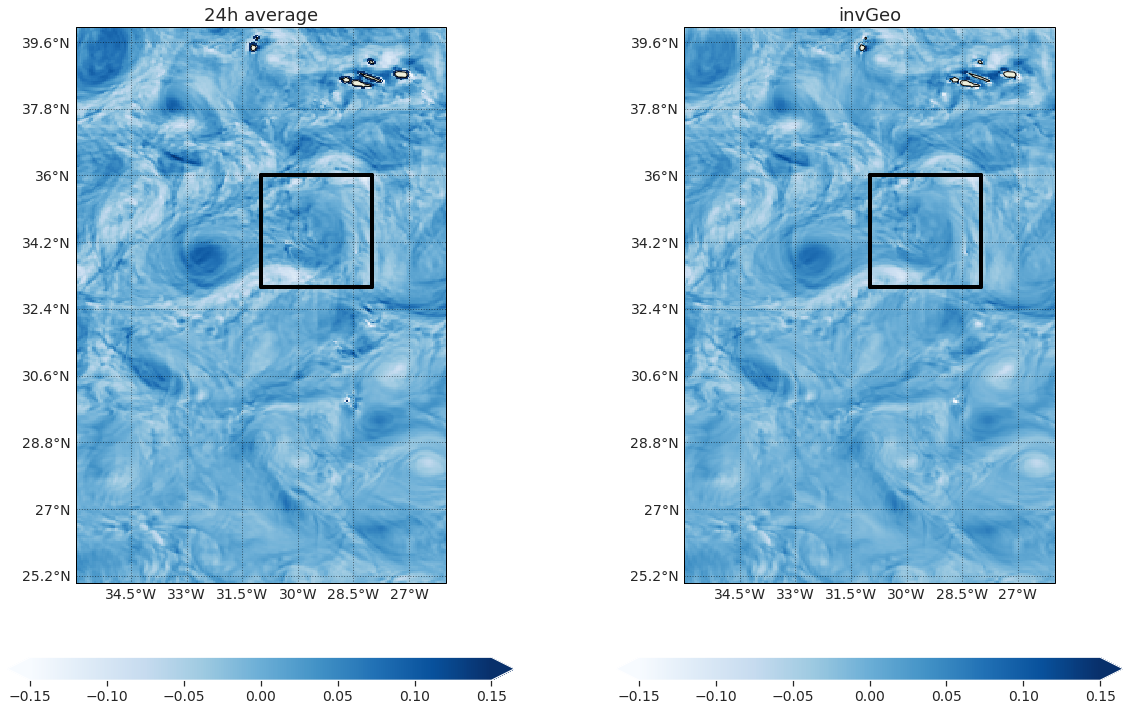

In [13]:
fig = plt.figure(figsize=(20,30))

plot_surf(221,Mrv_fromSSH_ave24h_JFM,navlon,navlat,-0.15,0.15,seq_cmap,'24h average')
plot_surf(222,Mrv_fromSSH_invGeo_JFM,navlon,navlat,-0.15,0.15,seq_cmap,'invGeo')

In [14]:
Mrv_fromSSH_ave24h_JFM

<xarray.DataArray 'rv_fromSSH_ave24h' (y: 397, x: 261)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.58921918e-03, -5.51768532e-03, ...,
        -3.91084608e-03,  5.73363304e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.26770185e-02, -5.83583897e-04, ...,
        -3.55863594e-03,  5.59390736e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -5.90151101e-02, -6.52994066e-02, ...,
        -6.34475723e-02,  8.76199436e+00,  0.00000000e+00],
       [ 0.00000000e+00, -5.24934009e-02, -6.72868341e-02, ...,
        -4.26552407e-02,  8.71153545e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]], dtype=float32)
Dimensions without coordinates: y, x

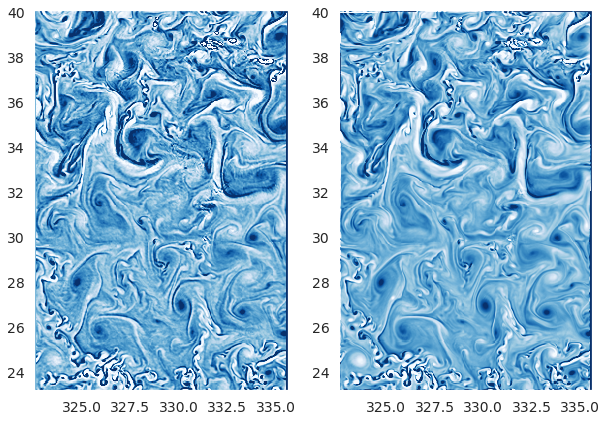

In [30]:
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


#plot_surf(221,Mrv_fromSSH_ave24h_JFM,navlon,navlat,-0.15,0.15,seq_cmap,'24h average')
#plot_surf(222,Mrv_fromSSH_invGeo_JFM,navlon,navlat,-0.15,0.15,seq_cmap,'invGeo')

def animate(i):
    
    ax1.pcolormesh(navlon,navlat,rv_over_f_24h_JFM[i,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)
    ax2.pcolormesh(navlon,navlat,rv_over_f_invGeo_JFM[i,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)
    

anim = FuncAnimation(fig, animate, frames=50, interval=50,repeat=False)
anim.save('RV_Acores.mp4')

In [31]:
#HTML(anim.to_html5_video())

In [41]:
rv_calc = ssh2rv(sshnotideJFM,navlon,navlat)
rv_calc_over_f = rv_calc/f
print(rv_calc_over_f)

[[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00 -5.0855745e-02 -7.5171277e-02 ...  3.5081074e-02
    2.6564751e+00  0.0000000e+00]
  [ 0.0000000e+00 -1.9865908e-01 -2.6284453e-01 ...  1.1940827e-02
    2.6449060e+00  0.0000000e+00]
  ...
  [ 0.0000000e+00  1.0902702e-01  1.7886800e-01 ... -2.3819867e-01
    4.6809082e+00  0.0000000e+00]
  [ 0.0000000e+00 -4.0104285e-02 -1.0016559e-03 ... -1.7738916e-01
    4.9075184e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]]

 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00 -5.8620073e-02 -8.1727080e-02 ...  3.2688487e-02
    2.4870427e+00  0.0000000e+00]
  [ 0.0000000e+00 -2.1253742e-01 -2.7744931e-01 ...  1.7853828e-02
    2.4857812e+00  0.0000000e+00]
  ...
  [ 0.0000000e+00  8.7137811e-02  1.9015190e-01 ... -2.2770870e-01
    4.3804

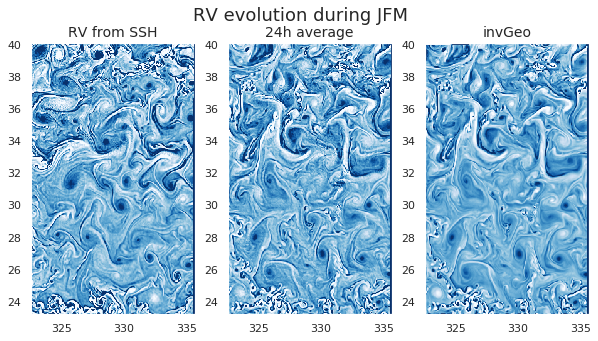

In [67]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#plot_surf(221,Mrv_fromSSH_ave24h_JFM,navlon,navlat,-0.15,0.15,seq_cmap,'24h average')
#plot_surf(222,Mrv_fromSSH_invGeo_JFM,navlon,navlat,-0.15,0.15,seq_cmap,'invGeo')


ax1.pcolormesh(navlon,navlat,rv_calc_over_f[0,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)
ax2.pcolormesh(navlon,navlat,rv_over_f_24h_JFM[0,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)
ax3.pcolormesh(navlon,navlat,rv_over_f_invGeo_JFM[0,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)

plt.suptitle('RV evolution during JFM',size=18)
ax1.set_title('RV from SSH', size=14, y=1.0)
ax2.set_title('24h average', size=14, y=1.0)
ax3.set_title('invGeo', size=14, y=1.0)


def animate(i):
    ax1.pcolormesh(navlon,navlat,rv_calc_over_f[i,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)
    ax2.pcolormesh(navlon,navlat,rv_over_f_24h_JFM[i,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)
    ax3.pcolormesh(navlon,navlat,rv_over_f_invGeo_JFM[i,:,:],cmap=seq_cmap,vmin=-0.15,vmax=0.15)
    
    
    
anim = FuncAnimation(fig, animate, frames=10, interval=250,repeat=False) # frames=30, interval=250
anim.save('RV_Acores_upd.mp4')